# Deterministic LQR design and its relation to Value Functions depicted on a Cartpole system.

In [2]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt

In [3]:
def plot_sim(state_hist, dt):
    t = np.linspace(0, state_hist.shape[0]*dt, state_hist.shape[0])
    plt.figure()
    plt.plot(t, state_hist[:, 0], label='$x$ in [m]', color='blue')
    plt.plot(t, state_hist[:, 1], label='$\dot{x}$ in [m/s]', color='deepskyblue')
    plt.plot(t, state_hist[:, 2], label='$\phi$ in [rad]', color='green')
    plt.plot(t, state_hist[:, 3], label='$\dot{\phi}$ in [rad/s]', color='lime')
    plt.xlabel('$t$ in [s]')
    plt.legend()
    plt.show()

def plot_poles(w):
    
    for i in range(w.shape[0]):
        abs = np.sqrt(np.square(w[i].real) + np.square(w[i].imag))
        print(f'abs eigenvalue {i+1} = {np.round(abs, 3)} ')

## Cartpole

<center><img width="350"  align="right" src="cartpole.png" /></center>

**State Variables:** <br>
- cart position $x$<br>
- cart velocity $\dot{x}$<br>
- pole angle $\phi$<br>
- pole angular velocity $\dot{\phi}$<br>

**Controlled Variable:**<br>
- control force $F$ <br>

**Model Parameters:**<br>
- gravitational acceleration $g$ <br>
- mass cart $m_c$<br>
- mass pole $m_p$<br>
- length pole $l$<br>
- friction coefficient cart $\mu_c$<br>
- friction coefficient pole $\mu_p$<br>


We can derive the (nonlinear) equations of motion. However, to model the cartpole as an LTI system, we need linearize those around a point of operation we are concerened with.

In [4]:
#simulation /discretization parameters
dt = 0.01
sim_time = 10

#cartpole parameters
g = 9.81
m_c = 1
m_p = 0.1
l = 0.5
mu_c = 0.1
mu_p = 0.05

## Linearisation around lower equilibrium


<center><img width="350"  align="right" src="cartpole_down.png" /></center>
$$
\begin{align}
\dot{x} &= A x + B u \\
  \begin{bmatrix}
  \dot{x}\\
  \ddot{x}\\
  \dot{\phi}\\
  \ddot{\phi}\\
  \end{bmatrix}
  &=
  \begin{bmatrix}
    0 & 1 & 0 & 0\\
    0 & -\frac{\mu_c}{m_c} & \frac{m_p \cdot g}{m_c} & 0\\
    0 & 0 & 0 & 1\\
    0 & 0 & -\frac{(m_p + m_c)g}{m_c \cdot l} & -\frac{\mu_p}{m_p \cdot l}\\
  \end{bmatrix}
  \begin{bmatrix}
  x\\
  \dot{x}\\
  \phi\\
  \dot{\phi}\\
  \end{bmatrix}
  +
  \begin{bmatrix}
  0\\
  \frac{1}{m_c}\\
  0\\
  -\frac{1}{m_c \cdot l}\\
  \end{bmatrix}
  F
\end{align}
$$

In [5]:
# state space matrices
A_down = np.array([[0, 1, 0, 0], [0, -mu_c/m_c, (m_p*g)/m_c, 0], [0, 0, 0, 1], [0, 0, -(m_p+m_c)*g/(m_c*l), -(mu_p)/(m_p*l)]])
B_down = np.array([[0], [1/m_c], [0], [-1/(m_c*l)]])
C_down = np.eye(4)
D_down = np.zeros([4, 1])
# continous time state space model
sys_c_down = ct.StateSpace(A_down, B_down, C_down, D_down)

## Discretization
$\dot{x} = A x + B u \rightarrow x_{t+1} = A x_t + B u_t $

In [6]:
#discrete time state space model
sys_d_down = sys_c_down.sample(dt)

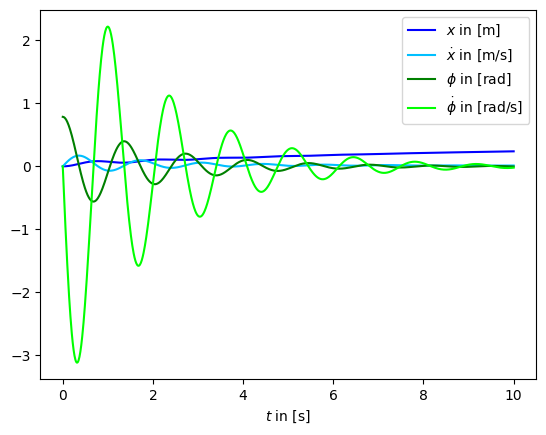

In [7]:
#set initial state
state = np.array([[0], [0], [np.pi/4], [0]])

state_hist = np.empty([int(sim_time/dt), sys_d_down.A.shape[0]])
for i in range(int(sim_time/dt)):
    state_hist[i, :] = np.transpose(state)
    u = 0
    state = sys_d_down.dynamics(dt, state, u)
    state = np.expand_dims(state, axis=1)

plot_sim(state_hist, dt)

# Linearisation around upper equilibrium

<center><img width="350"  align="right" src="cartpole_up.png" /></center>

$$
\begin{align}
\dot{x} &= A x + B u \\
  \begin{bmatrix}
  \dot{x}\\
  \ddot{x}\\
  \dot{\phi}\\
  \ddot{\phi}\\
  \end{bmatrix}
  &=
  \begin{bmatrix}
    0 & 1 & 0 & 0\\
    0 & -\frac{\mu_c}{m_c} & \frac{m_p \cdot g}{m_c} & 0\\
    0 & 0 & 0 & 1\\
    0 & 0 & \frac{(m_p + m_c)g}{m_c \cdot l} & -\frac{\mu_p}{m_p \cdot l}\\
  \end{bmatrix}
  \begin{bmatrix}
  x\\
  \dot{x}\\
  \phi\\
  \dot{\phi}\\
  \end{bmatrix}
  +
  \begin{bmatrix}
  0\\
  \frac{1}{m_c}\\
  0\\
  \frac{1}{m_c \cdot l}\\
  \end{bmatrix}
  F
 \end{align}
$$

In [8]:
# state space matrices
A_up = np.array([[0, 1, 0, 0], [0, -mu_c/m_c, (m_p*g)/m_c, 0], [0, 0, 0, 1], [0, 0, (m_p+m_c)*g/(m_c*l), -(mu_p)/(m_p*l)]])
B_up = np.array([[0], [1/m_c], [0], [1/(m_c*l)]])
C_up = np.eye(4)
D_up = np.zeros([4, 1])
# continous time state space model
sys_c_up = ct.StateSpace(A_up, B_up, C_up, D_up)


## Discretization
$\dot{x} = A x + B u \rightarrow x_{t+1} = A x_t + B u_t $

In [9]:
#discrete time state space model
sys_d_up = sys_c_up.sample(dt)

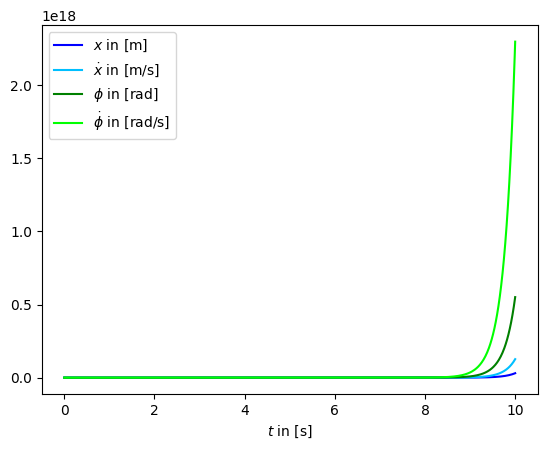

In [10]:
#set initial state
state = np.array([[0], [0], [np.pi/4], [0]])

state_hist = np.empty([int(sim_time/dt), sys_d_down.A.shape[0]])
for i in range(int(sim_time/dt)):
    state_hist[i, :] = np.transpose(state)
    u = 0
    state = sys_d_up.dynamics(dt, state, u)
    state = np.expand_dims(state, axis=1)

plot_sim(state_hist, dt)

# Stability

We have seen: Some systems are stable, others are not.<br>
Asymptotics stability means: 
$\lim_{t \to \infty} x_t = \tilde{x}$ with $\tilde{x} = 0$.<br>
In discrete time control systems we can check for stability looking at the eigenvalues $\lambda_i$ of $A$.<br>
If all $| \lambda_i | < 1$ then the system is stable.

### Linearisation around lower equilibrium

In [11]:
w_down, _ = np.linalg.eig(sys_d_down.A)
plot_poles(w_down)

abs eigenvalue 1 = 1.0 
abs eigenvalue 2 = 0.999 
abs eigenvalue 3 = 0.995 
abs eigenvalue 4 = 0.995 


### Linearisation around upper equilibrium

In [12]:
w_up, _ = np.linalg.eig(sys_d_up.A)
plot_poles(w_up)

abs eigenvalue 1 = 1.0 
abs eigenvalue 2 = 0.999 
abs eigenvalue 3 = 1.043 
abs eigenvalue 4 = 0.95 


# Controller Design

To stabilize the upper equilibrium, we synthesize a linear quadratic regulator (LQR). The idea is to design an optimal controller, such that cost for each start state $x_t$ <br>
$ J = \sum_{k=t}^{\infty}\left[ x_k^T Q x_k + u_k^T R u_k \right] $ is minimized. <br>

In [13]:
Q = np.eye(4)*1
R = 1
K, _, _ = ct.dlqr(sys_d_up, Q, R)
K = -1*K

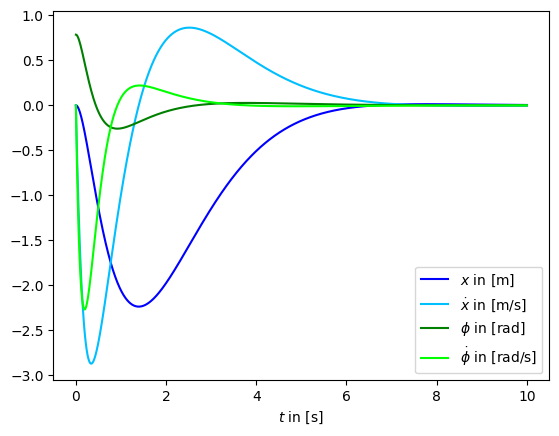

In [14]:
state_hist = np.empty([int(sim_time/dt), sys_d_up.A.shape[0]])

# set initial state
state = np.array([[0], [0], [np.pi/4], [0]])
for i in range(int(sim_time/dt)):
    state_hist[i, :] = np.transpose(state)
    u = np.matmul(K, state)[0]
    state = sys_d_up.dynamics(dt, state, u)
    state = np.expand_dims(state, axis=1)

plot_sim(state_hist, dt)

In [15]:
A_hat_up = sys_d_up.A+np.matmul(sys_d_up.B, K)
Q_hat_up = Q + np.matmul(np.transpose(K)*R, K)
w_hat_up, _ = np.linalg.eig(A_hat_up)
plot_poles(w_hat_up)

abs eigenvalue 1 = 0.943 
abs eigenvalue 2 = 0.964 
abs eigenvalue 3 = 0.992 
abs eigenvalue 4 = 0.992 


# Value function

Minimizing cost in optimal control is very similar to maximizing reward in reinforcement learning. <br>
We computed value functions for policies that gave us the expected return for different states when following that policy (here simplified for a deterministic setting with $\gamma = 1$) <br>
$v_{\pi}(s_t) = \sum_{k=t}^{\infty} r_{k+1}$ . <br>
<br>
If we now consider the LQR controller as a policy and define the cost of each timestep times -1 as the reward of this timestep, we can find the analogy<br>
$v_{LQR}(x_t) = - \sum_{k=t}^{\infty}\left[ x_k^T Q x_k + u_k^T R u_k \right]$

With the controller we have $u_t = K x_t$ <br>
Let $\hat{A} = A + B K$, and $\hat{Q} = Q + K^T R K$. Then $x_{t+1} = \hat{A}x_t$ and consequently $x_t = \hat{A}^t x_0$ .<br>
It follows
$x_k^T Q x_k + u_k^T R u_k = x_k^T \hat{Q} x_k = x_0^T(\hat{A}^k)^T \hat{Q} \hat{A}^k x_0$.<br>
Therefore <br>
$$ v_{LQR}(x_t) = - \sum_{k=0}^{\infty}\left[ x_t^T (\hat{A}^{k})^T \hat{Q} \hat{A}^{k} x_t \right] = -x_t^T\left[ \sum_{k=0}^{\infty} (\hat{A}^{k})^T \hat{Q} \hat{A}^{k}\right] x_t $$

If $\hat{A}$ is stable, one can show that the above converges to <br>
$$v_{LQR}(x_t) = -x_t^T X x_t$$ <br>
where $X$ is the (constant) solution to the discrete time Lyapunov equation $\hat{A} X \hat{A}^T - X + \hat{Q} = 0$.

In [16]:
X = ct.dlyap(A_hat_up, Q_hat_up)

In [17]:
state = np.array([[2], [1], [np.pi/4], [0]])
value = -1*np.matmul(np.matmul(np.transpose(state), X), state)
print(f'state: {np.transpose(state)}, state value: {np.round(value[0][0], 3)}')

state: [[2.         1.         0.78539816 0.        ]], state value: -7554303.115
